In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
import matplotlib.pyplot as plt

In [5]:
mnist_data = torchvision.datasets.FashionMNIST('D:/fastai/miniai',download=True)

In [6]:
# mnist_data.classes,mnist_data.class_to_idx

In [7]:
z = transforms.PILToTensor()
X,y = zip(*[(z(x),y) for x,y in mnist_data])
X,y = torch.stack(X),torch.tensor(y)

In [8]:
X_train,y_train = X[:50000].float(),y[:50000]
X_valid,y_valid = X[50000:].float(),y[50000:]

In [9]:
class DS():
    def __init__(self,x,y):
        self.x,self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        return self.x[idx]/255.0,self.y[idx]

In [10]:
train_ds,valid_ds = DS(X_train,y_train),DS(X_valid,y_valid)

In [11]:
bs = 256
train_dl = DataLoader(train_ds,shuffle=True,batch_size=bs,drop_last=True,num_workers=0)
valid_dl = DataLoader(valid_ds,shuffle=False,batch_size=bs*4,drop_last=False,num_workers=0)

In [13]:
from learner import Learner,DeviceCB,MetricsCB,PlotCB
from utils import to_cpu,Hook,set_seed,clean_mem,summary,show_images
from init import ActivationStats,Normalizer,LsuvInit,get_modules
from torchmetrics import Accuracy,MeanMetric

In [14]:
from scheds import LRfinderCB,one_cycle_schedfuncs,Schedule,BatchScheduleCB

In [15]:
class ConvBlock(nn.Module):
    def __init__(self,ni,nf,ks=3,stride=2,batch_norm=False,act=True):
        super().__init__()
        bias = not batch_norm
        l = [nn.Conv2d(ni,nf,ks,stride=stride,padding=ks//2,bias=bias)]
        if batch_norm:l.append(nn.BatchNorm2d(nf))
        if act:l.append(nn.LeakyReLU(0.1))
        self.conv_block = nn.Sequential(*l)  
    
    def forward(self,x):
        return self.conv_block(x)
        

In [16]:
class ResBlock(nn.Module):
    def __init__(self,ni,nf,ks=3,stride=2,*args,**kwargs):
        super().__init__()
        self.conv1 = ConvBlock(ni,nf,ks,stride=1,batch_norm=True,act=True)
        self.conv2 = ConvBlock(nf,nf,ks,stride=stride,batch_norm=True,act=False)
        
        skip = []
        if stride==2:skip.append(nn.AvgPool2d(2,ceil_mode=True))
        if ni!=nf:skip.append(ConvBlock(ni,nf,1,1,batch_norm=False,act=False))
        if len(skip)==0:skip=[nn.Identity()]
        self.skip = nn.Sequential(*skip)
        
        self.act = nn.LeakyReLU(0.1)
    def forward(self,x):
        return self.act(self.conv2(self.conv1(x))+self.skip(x))

In [17]:
def get_model(block,ni_s=(8,16,32,64,128),batch_norm=False,global_avg=True,n_out=10,drop=0.1):
    l = [Normalizer(1),ConvBlock(1,ni_s[0],5,1),nn.Dropout2d(drop)]
    for i in range(len(ni_s)-1):l.append(block(ni_s[i],ni_s[i+1],batch_norm=batch_norm))
    if global_avg:l.append(nn.AdaptiveAvgPool2d((1,1)))
    l += [nn.Flatten(),nn.Dropout(drop),nn.Linear(ni_s[- 1],n_out)]
    return nn.Sequential(*l)

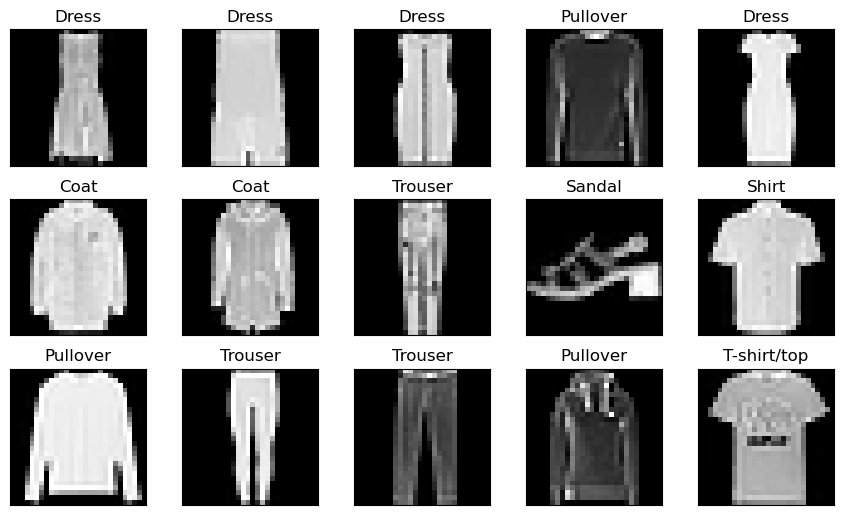

In [18]:
batch = next(iter(train_dl))
show_images(batch[0],batch[1],scale=1.75,tfmx=lambda x:x[0],tfmy=lambda y:mnist_data.classes[y],cmap="gray")

In [19]:
set_seed(1)
m = get_model(ResBlock,(16,32,64,128,256),batch_norm=True,global_avg=True)
loss_func = F.cross_entropy
lr = 1e-1
optim=torch.optim.Adam(m.parameters(),lr=lr)
cbs = [DeviceCB()]
learner = Learner(m,loss_func,optim,cbs=cbs)

is cuda available:False
device count:0


In [21]:
summary(learner,train_dl)

Total number of parameters:1223948
Total number of parameters:13.278331999999999


,Module,InputShape,OutputShape,NumParams,PercentageParams,Mflops
0,Normalizer,"((256, 1, 28, 28),)","(256, 1, 28, 28)",2,0.000002,0.000002
1,ConvBlock,"((256, 1, 28, 28),)","(256, 16, 28, 28)",416,0.000340,0.313616
2,Dropout2d,"((256, 16, 28, 28),)","(256, 16, 28, 28)",0,0.000000,0.000000
3,ResBlock,"((256, 16, 28, 28),)","(256, 32, 14, 14)",14496,0.011844,2.810016
4,ResBlock,"((256, 32, 14, 14),)","(256, 64, 7, 7)",57664,0.047113,2.810176
5,ResBlock,"((256, 64, 7, 7),)","(256, 128, 4, 4)",230016,0.187930,3.670656
6,ResBlock,"((256, 128, 4, 4),)","(256, 256, 2, 2)",918784,0.750672,3.671296
7,AdaptiveAvgPool2d,"((256, 256, 2, 2),)","(256, 256, 1, 1)",0,0.000000,0.000000
8,Flatten,"((256, 256, 1, 1),)","(256, 256)",0,0.000000,0.000000
9,Dropout,"((256, 256),)","(256, 256)",0,0.000000,0.000000


In [22]:
LsuvInit(learner,get_modules(m,(nn.Conv2d,nn.Linear)),train_dl,take_first_batch= True)

Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(-0.0131) tensor(0.9292)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(0.0005) tensor(0.9989)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(8.4703e-06) tensor(1.0000)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(1.2662e-07) tensor(1.0000)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0324) tensor(0.7308)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0477) tensor(0.9935)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0481) tensor(1.0041)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0430) tensor(1.0035)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0466) tensor(0.9895)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

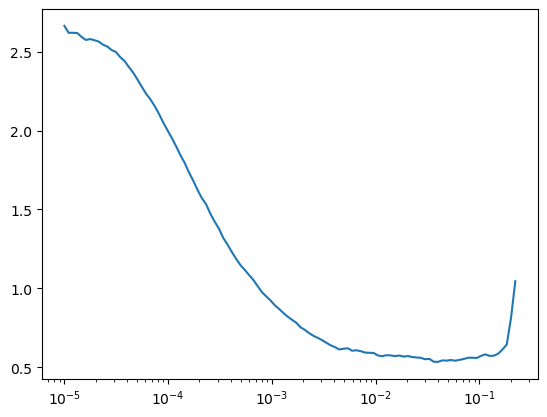

In [23]:
learner.fit(train_dl,3,tmp_cbs=[LRfinderCB()])

In [24]:
set_seed(1)
m = get_model(ResBlock,(16,32,64,128,256),batch_norm=True,global_avg=True,drop=0.2)
loss_func = F.cross_entropy
lr = 2e-2
optim=torch.optim.Adam(m.parameters(),lr=lr)
cbs = [DeviceCB(),MetricsCB(Accuracy("multiclass",num_classes=10)),PlotCB(1)]
learner = Learner(m,loss_func,optim,cbs=cbs)

LsuvInit(learner,get_modules(m,(nn.Conv2d,nn.Linear)),train_dl,take_first_batch= True)

is cuda available:False
device count:0
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(-0.0139) tensor(0.9311)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(0.0005) tensor(0.9989)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(7.2837e-06) tensor(1.0000)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(8.6594e-08) tensor(1.0000)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0318) tensor(0.7848)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0388) tensor(0.9565)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0436) tensor(1.0301)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0423) tensor(0.9856)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0430) tensor(1.0196)
Conv2d(16, 32, kernel_size=

In [25]:
act_stats = ActivationStats(get_modules(m,(ResBlock)))

epochs = 20

lr_scheds,betas_scheds = one_cycle_schedfuncs(epochs*len(train_dl),beta2=0.999,max_lr=[lr])
sched_cb = BatchScheduleCB(Schedule(learner.optim,lr=lr_scheds,betas=betas_scheds))

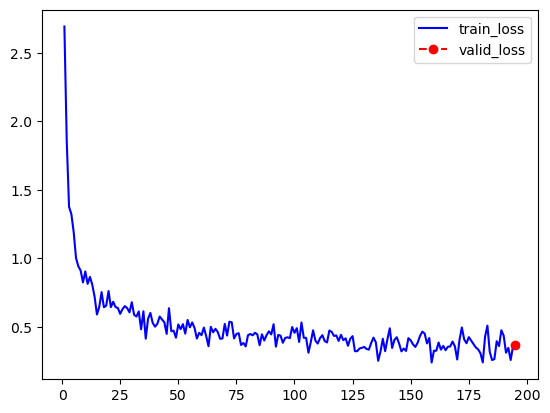

{'epoch': 1, 'istrain': True, 'loss': tensor(0.4932), 'MulticlassAccuracy': tensor(0.8236)}
{'epoch': 1, 'istrain': False, 'loss': tensor(0.3672), 'MulticlassAccuracy': tensor(0.8652)}
{'epoch': 2, 'istrain': True, 'loss': tensor(0.3271), 'MulticlassAccuracy': tensor(0.8790)}



KeyboardInterrupt



In [26]:
learner.fit(train_dl,epochs,valid_dl,[sched_cb])

In [ ]:
act_stats.plot_stats()

In [ ]:
act_stats.plot_histograms((20,10))

In [ ]:
act_stats.plot_dead_chart()

In [31]:
set_seed(1)
m = nn.Sequential(Normalizer(1),get_model(ResBlock,(16,32,64,128,256),batch_norm=True,global_avg=True))
loss_func = F.cross_entropy
lr = 2e-2
optim=torch.optim.Adam(m.parameters(),lr=lr)
cbs = [DeviceCB(),MetricsCB(Accuracy("multiclass",num_classes=10)),PlotCB(1)]
learner = Learner(m,loss_func,optim,cbs=cbs)

LsuvInit(learner,get_modules(m,(nn.Conv2d,nn.Linear)),train_dl,take_first_batch= True)

is cuda available:False
device count:0
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(-0.0139) tensor(0.9311)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(0.0005) tensor(0.9989)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(7.2837e-06) tensor(1.0000)
Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) tensor(8.6594e-08) tensor(1.0000)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0332) tensor(0.6848)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) tensor(-0.0484) tensor(1.)
Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) tensor(0.0356) tensor(0.7396)
Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) tensor(0.0482) tensor(1.)
Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1)) tensor(-0.0707) tensor(0.4885)
Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1)) tensor(-0.0785)

In [32]:
act_stats = ActivationStats(get_modules(m,(nn.Conv2d)))

epochs = 20

lr_scheds,betas_scheds = one_cycle_schedfuncs(epochs*len(train_dl),beta2=0.999,max_lr=[lr])
sched_cb = BatchScheduleCB(Schedule(learner.optim,lr=lr_scheds,betas=betas_scheds))

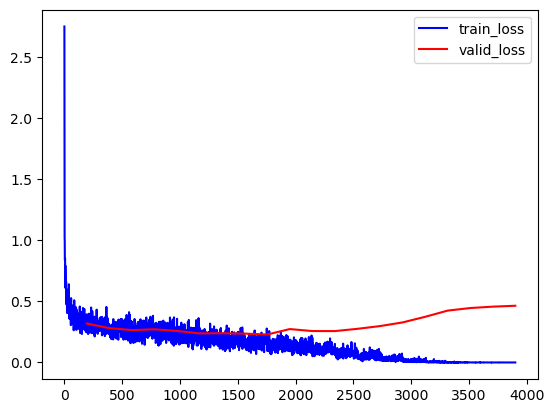

{'epoch': 1, 'istrain': True, 'loss': tensor(0.4207), 'MulticlassAccuracy': tensor(0.8486)}
{'epoch': 1, 'istrain': False, 'loss': tensor(0.3187), 'MulticlassAccuracy': tensor(0.8824)}
{'epoch': 2, 'istrain': True, 'loss': tensor(0.2966), 'MulticlassAccuracy': tensor(0.8907)}
{'epoch': 2, 'istrain': False, 'loss': tensor(0.2812), 'MulticlassAccuracy': tensor(0.8982)}
{'epoch': 3, 'istrain': True, 'loss': tensor(0.2723), 'MulticlassAccuracy': tensor(0.8986)}
{'epoch': 3, 'istrain': False, 'loss': tensor(0.2647), 'MulticlassAccuracy': tensor(0.9030)}
{'epoch': 4, 'istrain': True, 'loss': tensor(0.2548), 'MulticlassAccuracy': tensor(0.9052)}
{'epoch': 4, 'istrain': False, 'loss': tensor(0.2716), 'MulticlassAccuracy': tensor(0.8981)}
{'epoch': 5, 'istrain': True, 'loss': tensor(0.2379), 'MulticlassAccuracy': tensor(0.9111)}
{'epoch': 5, 'istrain': False, 'loss': tensor(0.2582), 'MulticlassAccuracy': tensor(0.9037)}
{'epoch': 6, 'istrain': True, 'loss': tensor(0.2196), 'MulticlassAccuracy':

In [33]:
learner.fit(train_dl,epochs,valid_dl,[sched_cb])

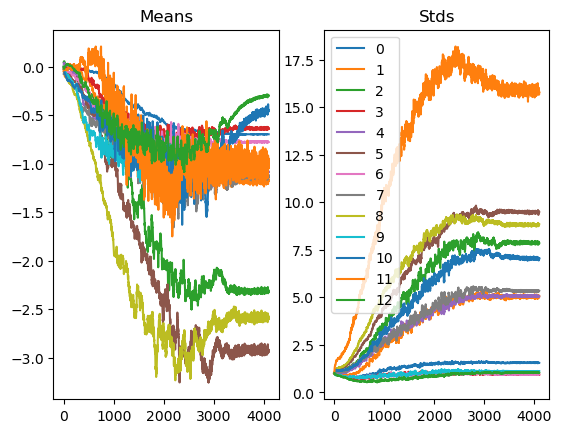

In [34]:
act_stats.plot_stats()

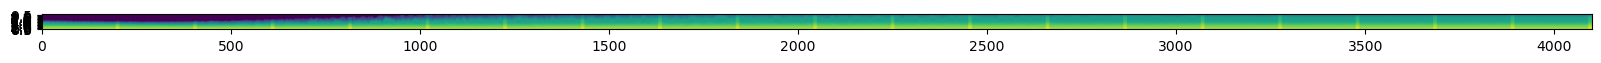

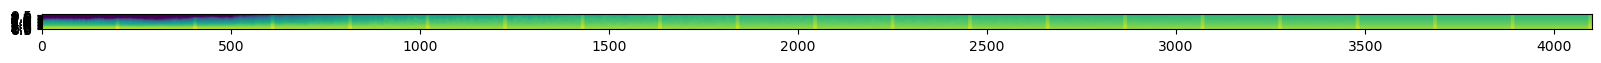

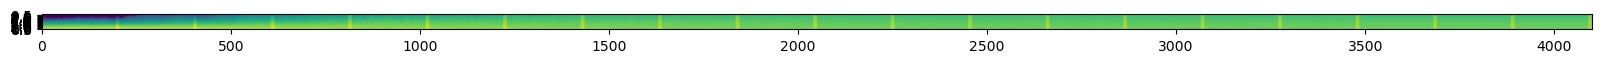

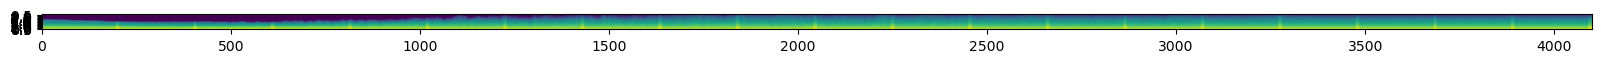

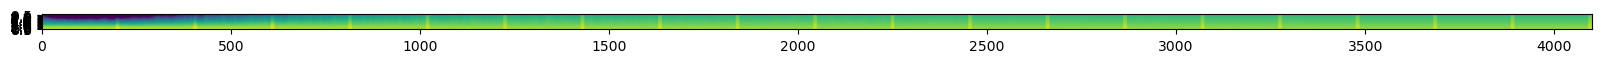

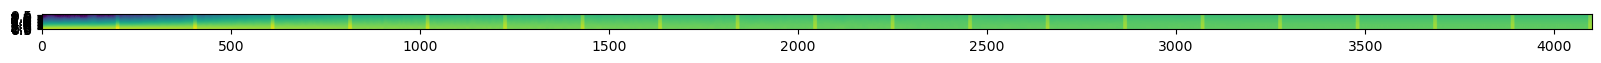

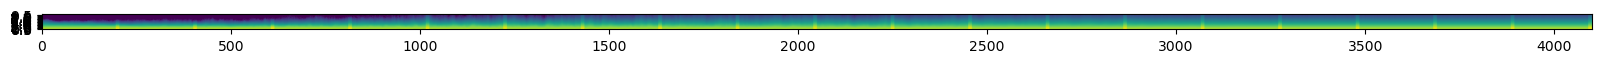

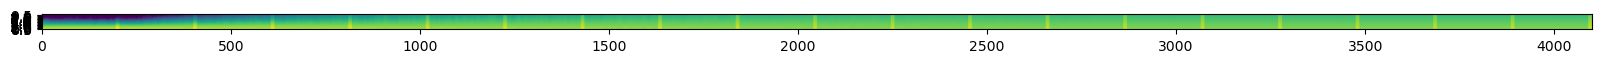

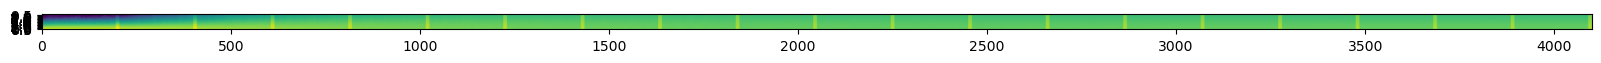

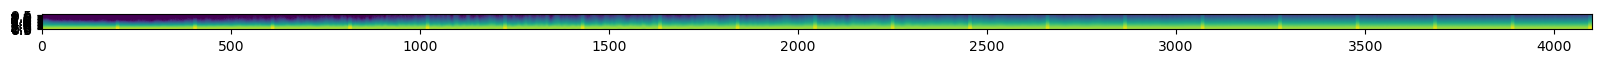

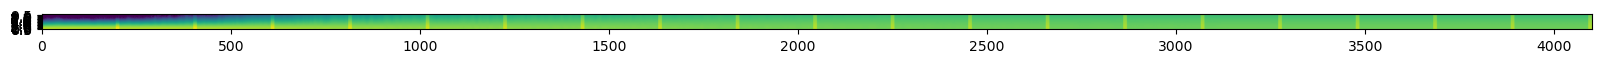

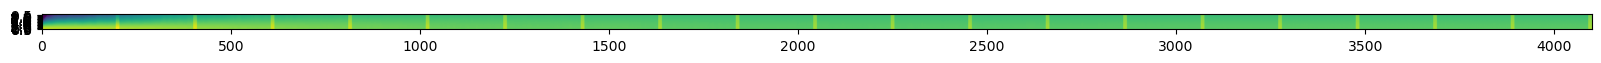

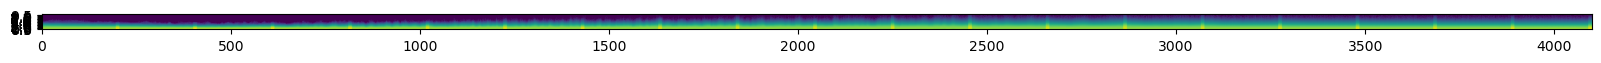

In [35]:
act_stats.plot_histograms((20,10))

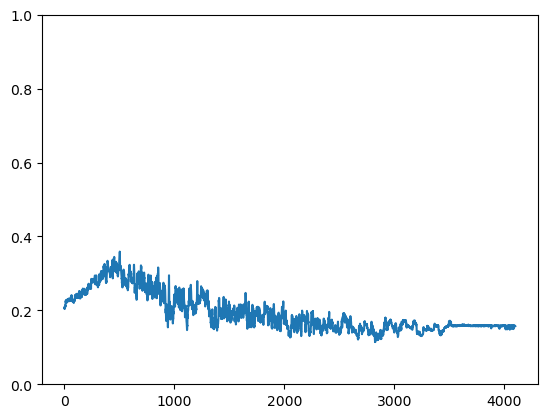

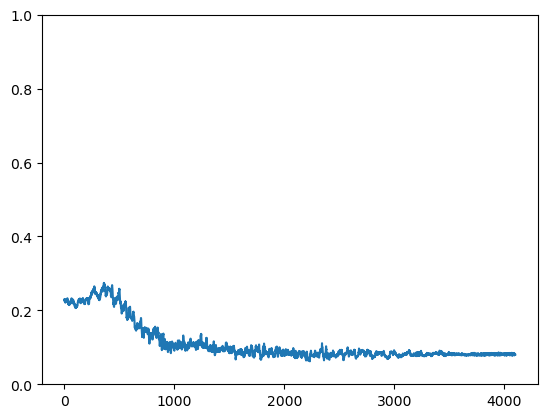

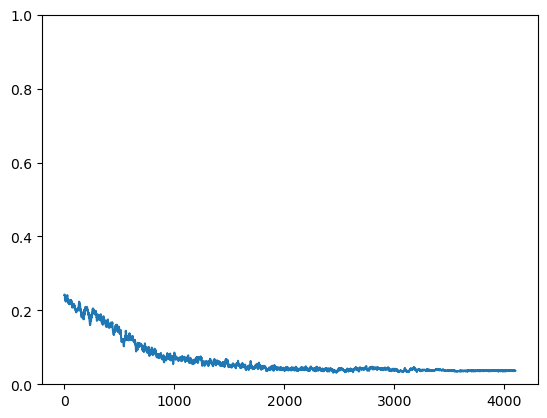

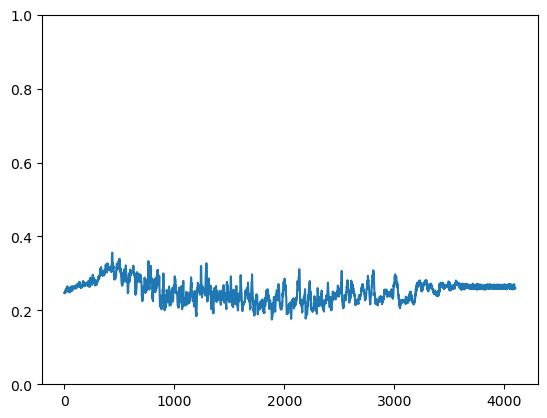

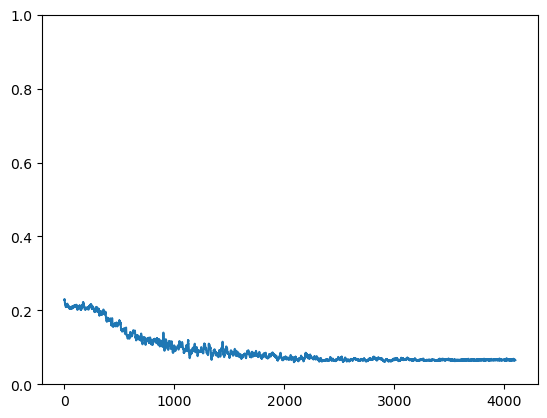

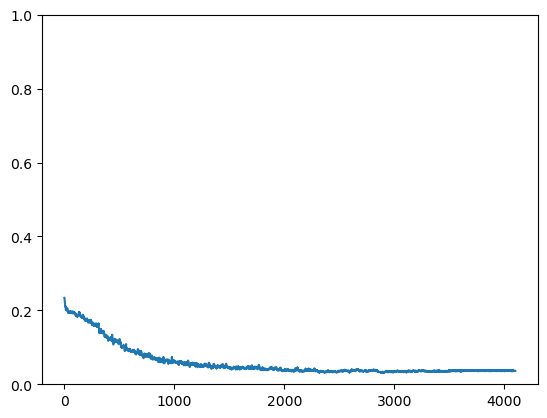

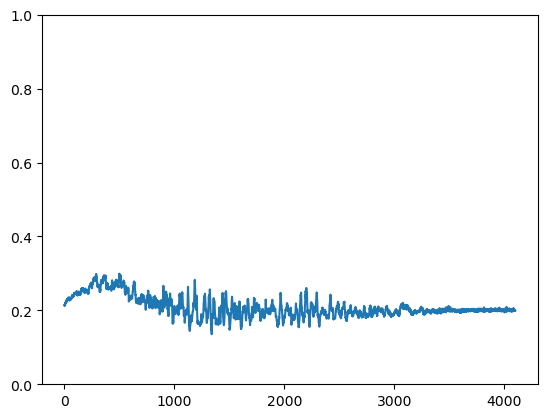

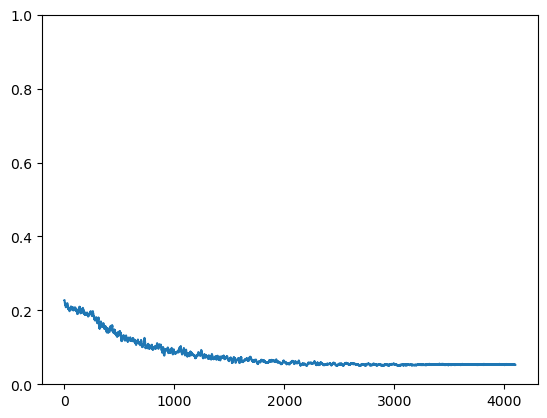

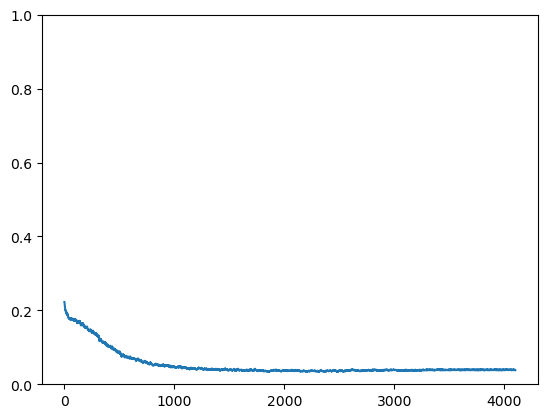

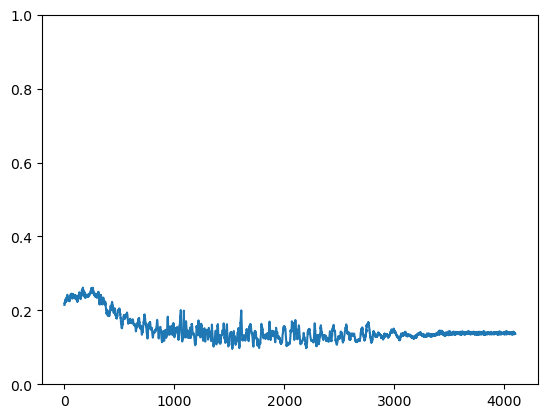

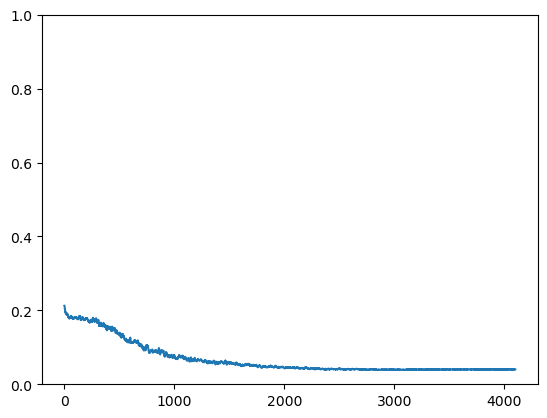

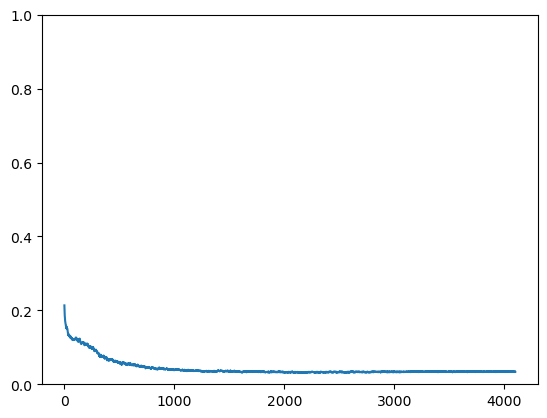

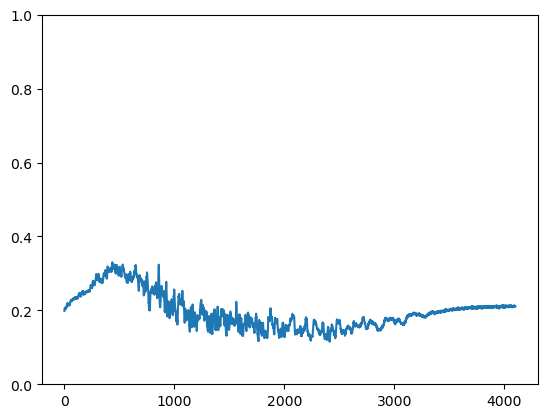

In [36]:
act_stats.plot_dead_chart()